In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/DNN_compression/structured_compression/
# PATH= '/content/drive/MyDrive/DNN_compression/structured_compression'

/content/drive/MyDrive/DNN_compression/structured_compression


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import scipy.optimize
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from pytorchtools import CNN, GaussianNoise
from adversarialbox.attacks import FGSMAttack, LinfPGDAttack_AE, WassDROAttack_AE, L2PGDAttack_AE
from adversarialbox.train import adv_train, FGSM_train_rnd
from adversarialbox.utils import to_var, pred_batch, test
from layers_compress import Encoder, Generator, Quantizer, AutoencoderQ#, StructuredCompressor, SingleEncMultiDec
import os
# from dro_tools import est_radius, est_radius_structured

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# matplotlib
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rcParams.update({'font.size': 13})
plt.rcParams.update({'lines.linewidth':1.25})
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = None
plt.rcParams['legend.edgecolor'] = 'inherit'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams["font.family"] = "serif"
# plt.rcParams['mathtext.default'] = 'regular'

In [12]:
transform_ood = torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(), 
    ])

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(32),
    torchvision.transforms.ToTensor()
])
batch_size = 1000

#     mnist_ood_train = torchvision.datasets.MNIST('../datasets/', train=True, download=True, transform=transform_ood)
mnist_train = torchvision.datasets.MNIST('../data/', train=True, download=True, transform=transform)

#     trainset = torch.utils.data.ConcatDataset([mnist_ood_train, mnist_train])
testset = torchvision.datasets.MNIST('../data/', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                     shuffle=False)

In [4]:

def loopy(dl):
    while True:
        for x in iter(dl): yield x

def obj_rot(theta, img_iterator, model, ball):
    x = next(img_iterator)[0].to(device)
    x_rotated = torchvision.transforms.functional.rotate(x, theta)
    x_hat = model(x_rotated) if ball==0 else model(x_rotated,1)
    loss = -32*32*F.mse_loss(x_rotated, x_hat).item()
    return loss

    
def argmax_theta(train_loader, model, ball):
    img_iterator = loopy(train_loader) #shuffles the train_loader
    obj = lambda theta: obj_rot(theta, img_iterator, model, ball)
    theta_max = scipy.optimize.minimize_scalar(obj, bounds=[-180, 180], method='bounded', options={'maxiter': 200, 'disp':3})
    return theta_max

def obj_rot2(theta, img_iterator, model):
    x = next(img_iterator)[0].to(device)
    x_rotated = torchvision.transforms.functional.rotate(x, theta)
    x_hat = model(x_rotated)
    loss = -32*32*F.mse_loss(x_rotated, x_hat).item()
    return loss

def gen_save_plot(train_loader, model):
    thetas = np.linspace(-179, 180, 360)
    d_dro = np.zeros(len(thetas))
    iterator = loopy(train_loader)
    for i,theta in enumerate(thetas):
        d_dro[i] = -obj_rot2(theta, iterator, model)
    return thetas, d_dro
    # plt.figure()
    # plt.plot(thetas, d_dro)
    # plt.axvline(theta_max, color='k',linestyle='--')
    # plt.xlabel('angle')
    # plt.ylabel('distortion')
    # plt.savefig(f'../plots_rotations/epoch{epoch}_batch{batch}.png')

In [5]:
d_pair = (6, 4)
L = 12
d = 10

In [6]:
saved = torch.load(f'trained_robust_rotations/ae_c_d{d}L{L}rotated_WTF.pt')
model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])

In [16]:
# saved = torch.load(f'trained_rotations/ae_c_d{d_pair[0]}-{d_pair[1]}L{L}rotated2.pt', map_location=device)
# model_struct = SingleEncMultiDec(saved['netE'], saved['netQ'], saved['dec_list'], saved['dim_list'])

# saved = torch.load(f'trained_dro_rotations/ae_c_d{d}L{L}rotated2.pt', map_location=device)
# model_dro = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])

# saved = torch.load(f'trained_no_robust/ae_c_d{d_pair[0]+d_pair[1]}L{L}.pt', map_location=device)
# model_std = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])

# saved = torch.load(f'../structured_compression/trained_augmentation/ae_c_d{d}L{L}rotation.pt', map_location=device)
# model_da = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])

FileNotFoundError: [Errno 2] No such file or directory: '../structured_compression/trained_augmentation/ae_c_d10L12rotation.pt'

In [ ]:
img_iter= iter(train_loader)


In [ ]:
# y = 0
# while y != 6:
#   samp = next(img_iter)
#   y = samp[1]
#   x = samp[0]
x = next(img_iter)[0]

In [ ]:
x_rot = torchvision.transforms.functional.rotate(x, 120)

In [ ]:
mask = 1 - (x_rot >= 0.5).float()

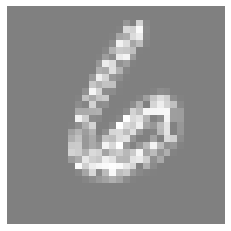

In [ ]:
plt.imshow(x_rot[0][0] + 0.5*mask[0][0], cmap='gray', vmin=0, vmax = 1)
# plt.imshow(x_rot[0][0] + 0.2*np.random.randn(32, 32), cmap='gray', vmin=0, vmax = 1)
plt.axis('off')
plt.savefig(f'6.pdf')

In [ ]:
x_recon_struct = model_struct(x_rot.to(device), 1).cpu()
d_struct = 32*32*F.mse_loss(x_rot, x_recon_struct).item()
x_recon_dro = model_dro(x_rot.to(device)).cpu()
d_dro = 32*32*F.mse_loss(x_rot, x_recon_dro).item()
x_recon_std = model_std(x_rot.to(device)).cpu()
d_std = 32*32*F.mse_loss(x_rot, x_recon_std).item()
x_recon_da = model_da(x_rot.to(device)).cpu()
d_da = 32*32*F.mse_loss(x_rot, x_recon_da).item()

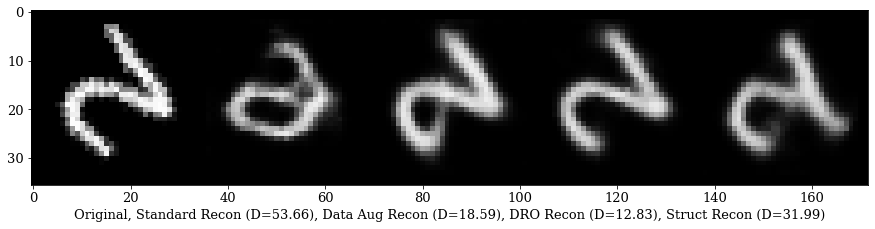

In [ ]:
# my_dpi=96
# plt.figure(constrained_layout=True, figsize=(1600/my_dpi, 400/my_dpi), dpi=my_dpi)
plt.figure(figsize=(15,7))
grid = torchvision.utils.make_grid([x_rot[0], x_recon_std[0], x_recon_da[0], x_recon_dro[0], x_recon_struct[0]],  nrow=5)
# grid = torchvision.utils.make_grid([decompressed1[0].cpu(), decompressed[0].cpu(),decompressed_rot[0].cpu(), decompressed_awgn1[0].cpu(),  decompressed_adv1[0].cpu()], nrow=5)
npimg = grid.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
# plt.axis('off')
plt.xlabel(f'Original, Standard Recon (D={d_std:.2f}), Data Aug Recon (D={d_da:.2f}), DRO Recon (D={d_dro:.2f}), Struct Recon (D={d_struct:.2f})')
plt.show()

In [ ]:
theta_dro = argmax_theta(train_loader, model_dro, 0)
# theta_std = argmax_theta(test_loader, model_std, 0)
theta_struct = argmax_theta(test_loader, model_struct, 1)
theta_da = argmax_theta(test_loader, model_da, 0)

In [ ]:
thetas = np.linspace(-179, 180, 360)
d_std = np.zeros(len(thetas))
d_dro = np.zeros(len(thetas))
d_da = np.zeros(len(thetas))
d_struct = np.zeros(len(thetas))
iterator = loopy(train_loader)
for i,theta in enumerate(thetas):
  d_dro[i] = -obj_rot(theta, iterator, model_dro, 0)
  d_std[i] = -obj_rot(theta, iterator, model_std, 0)
  d_da[i] = -obj_rot(theta, iterator, model_da, 0)
  d_struct[i] = -obj_rot(theta, iterator, model_struct, 1)

In [13]:
model.eval()
thetas, d_dro = gen_save_plot(train_loader, model)

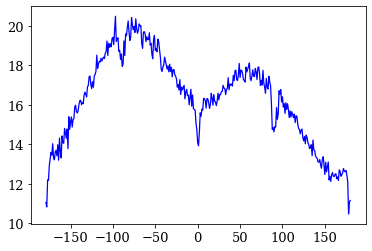

In [14]:
plt.plot(thetas, d_dro)

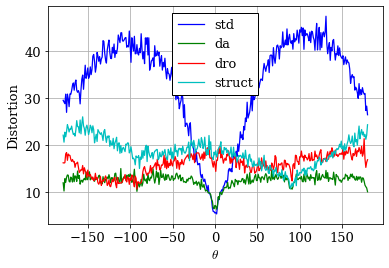

In [ ]:
plt.plot(thetas, d_std, label='std')
plt.plot(thetas, d_da, label='da')
plt.plot(thetas, d_dro, label='dro')
plt.plot(thetas, d_struct, label='struct')
plt.legend()
plt.xlabel(r'$\theta$')
plt.ylabel('Distortion')
# plt.xlim([-20, 20])
# plt.ylim([0, 10])
plt.grid()



plt.show()

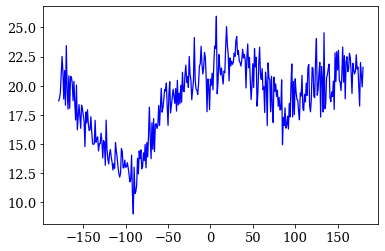

In [ ]:
plt.plot(thetas, d)

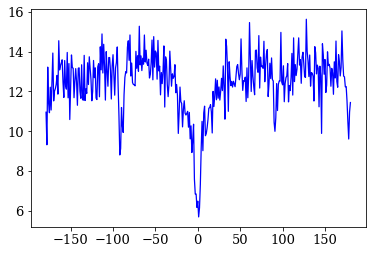

In [ ]:
plt.plot(thetas, d)

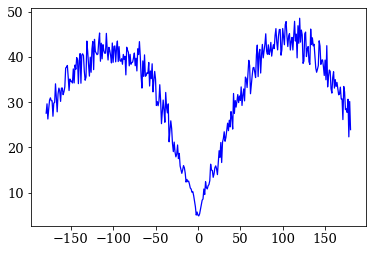

In [ ]:
plt.plot(thetas, d)

In [ ]:
print(theta_std, '\n')
print(theta_da, '\n')
print(theta_dro, '\n')
print(theta_struct, '\n')

     fun: -8.595952033996582
 message: 'Solution found.'
    nfev: 37
  status: 0
 success: True
       x: -168.5309487911429 

     fun: -9.041204452514648
 message: 'Solution found.'
    nfev: 41
  status: 0
 success: True
       x: -9.857265477532742 

     fun: -13.24340534210205
 message: 'Solution found.'
    nfev: 39
  status: 0
 success: True
       x: -141.29700556853413 

     fun: -12.924012184143066
 message: 'Solution found.'
    nfev: 37
  status: 0
 success: True
       x: -123.77004627247395 



In [ ]:
def adv_distortion(model, gamma, loader, *args):
    adversary = WassDROAttack_AE(model=model, k=15, a=1, gamma=gamma)
    dist = 0
    for data in loader:
        data = data[0].to(device)
        X_adv = adversary.perturb(data, None, *args)
        dist += F.mse_loss(X_adv, model(X_adv, *args)).item()*32*32
    return dist/len(loader)

def eval_robust(model, gammas, loader, *args):
    d = []
    for gamma in gammas:
        d += [adv_distortion(model, gamma, loader, *args)]
    return d

def center_distortion(model, loader, *args):
    dist = 0
    for data in loader:
        data = data[0].to(device)
        dist += F.mse_loss(data, model(data, *args)).item()*32*32
    return dist/len(loader)

def awgn_distortion(model, variance, loader, *args):
    dist = 0
    for data in loader:
        data = data[0].to(device)
        data_awgn = data + torch.randn(data.size(), device=device) * np.sqrt(variance)
        data_awgn = torch.clip(data_awgn, 0, 1)
        dist += F.mse_loss(data_awgn, model(data_awgn, *args)).item()*32*32
    return dist/len(loader)

def eval_awgn(model, variances, loader, *args):
    d = []
    for variance in variances:
        d += [awgn_distortion(model, variance, loader, *args)]
    return d


In [ ]:
noise_std = np.linspace(0., 0.25, 6)
epsilons = np.linspace(0, 10, 6)
L = 12
gamma=1.00
rho = 50
d_pair = (6,4)

__Estimate Radius__

In [ ]:
# Wass DRO
d = 10
saved = torch.load(f'trained_dro_NEW/ae_c_d{d}L{L}gamma{gamma:.2f}.pt', map_location=device)
model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])

In [ ]:
rho_WassDRO=est_radius(model, gamma, train_loader)
print(rho_WassDRO)

In [ ]:
# Structured 3
# saved = torch.load(f'trained_idea3_sweep_NEW/ae_c_d{d_pair[0]}-{d_pair[1]}L{L}gamma{gamma:.2f}.pt', map_location=device)
saved = torch.load(f'trained_idea3_annealed/ae_c_d{d_pair[0]}-{d_pair[1]}L{L}rho{rho}.pt', map_location=device)
model = SingleEncMultiDec(saved['netE'], saved['netQ'], saved['dec_list'], saved['dim_list'])
gamma = saved['gamma']
print(gamma)

0.41724453142123225


In [ ]:
rho_3 = est_radius_structured(model, gamma, train_loader, 1)
print(rho_3)

__Worst-case-distortion vs wasserstein radius__

In [ ]:
# load a model (for standard or wassDRO)
d = 10
saved = torch.load(f'trained_dro_NEW/ae_c_d{d}L{L}gamma{gamma:.2f}.pt', map_location=device)
# saved = torch.load(f'trained_dro_NEW/ae_c_d{d}L{L}gamma0.97rho20.1.pt', map_location=device)
# saved = torch.load(f'trained_dro_NEW/ae_c_d{d}L{L}rho50.pt', map_location=device)
# saved = torch.load(f'trained_no_robust/ae_c_d{d}L{L}.pt', map_location=device)
model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])

In [ ]:
# load a model (for structured)
# saved = torch.load(f'trained_idea3_sweep_NEW/ae_c_d{d_pair[0]}-{d_pair[1]}L{L}gamma{gamma:.2f}.pt', map_location=device)
saved = torch.load(f'trained_idea3_annealed/ae_c_d{d_pair[0]}-{d_pair[1]}L{L}rho{rho}.pt', map_location=device)
print(d_pair)
model = SingleEncMultiDec(saved['netE'], saved['netQ'], saved['dec_list'], saved['dim_list'])

(6, 4)


In [ ]:
# for wassDRO
# gammas = np.linspace(0.7, 2.1, 7)
gammas = np.append(np.linspace(0.75, 1.3, 5), np.linspace(1.5, 2.1, 3)) # zoomed
# gammas = np.linspace(0.1, 0.65, 5) # extended
rhos = np.zeros(len(gammas))

In [ ]:
# for standard
# gammas = np.linspace(1.6, 3.3, 7)
gammas = np.append(np.linspace(1.68, 2.2, 5), np.linspace(2.5, 3.3, 3))
rhos = np.zeros(len(gammas))

In [ ]:
dset = torch.utils.data.random_split(train_loader.dataset, [10000, 50000])[0]
train_loader2 = torch.utils.data.DataLoader(dset, batch_size=5000, shuffle=True)
for i, gamma in enumerate(gammas):
    # rhos[i] = est_radius(model, gamma, train_loader2)
    rhos[i] = est_radius_structured(model, gamma, train_loader2, 1) # for structured

30.539186477661133
30.615549087524414
24.01845359802246
24.076847076416016
18.554237365722656
18.510014533996582
13.714922904968262
13.654414176940918
9.96532917022705
9.957106590270996
6.793645858764648
6.76262903213501
4.374687194824219
4.442574739456177
3.244138240814209
3.21394419670105


In [ ]:
gammas, rhos

(array([0.75  , 0.8875, 1.025 , 1.1625, 1.3   , 1.5   , 1.8   , 2.1   ]),
 array([30.61554909, 24.07684708, 18.51001453, 13.65441418,  9.95710659,
         6.76262903,  4.44257474,  3.2139442 ]))

In [ ]:
gamma

2.1

In [ ]:
# wcd = eval_robust(model, gammas, test_loader)
wcd = eval_robust(model, gammas, test_loader, 1) # for structured

In [ ]:
rhos = np.array([33.06357956, 26.00177536, 19.26837807, 13.30605059,  9.12448797,
         5.69478693,  3.31326334,  2.18442006])

In [ ]:
rhos, wcd

(array([30.61554909, 24.07684708, 18.51001453, 13.65441418,  9.95710659,
         6.76262903,  4.44257474,  3.2139442 ]),
 [56.19197235107422,
  49.49111976623535,
  43.46491966247559,
  37.70221061706543,
  32.95410099029541,
  28.266990852355956,
  24.126517295837402,
  21.692424392700197])

In [ ]:
# for wassDRO
save = {'rhos': rhos, 'gammas': gammas, 'wcd': wcd}
torch.save(save, f'saved_results/wcd_wassDRO_d{d}L{L}gamma_train{1:.2f}_extended.pt')
# torch.save(save, f'saved_results/wcd_wassDRO_d{d}L{L}rho50_extended.pt')

In [ ]:
# for standard
save = {'rhos': rhos, 'gammas': gammas, 'wcd': wcd}
torch.save(save, f'saved_results/wcd_std_d{d}L{L}.pt')

In [ ]:
gamma = 1

In [ ]:
# for structured
save = {'rhos': rhos, 'gammas': gammas, 'wcd': wcd}
# torch.save(save, f'saved_results/wcd_structured_d{d_pair[0]}-{d_pair[1]}L{L}gamma_train{gamma:.2f}.pt')
torch.save(save, f'saved_results/wcd_structured_d{d_pair[0]}-{d_pair[1]}L{L}rho{rho}.pt')

In [ ]:
# d_pair = (7, 3)

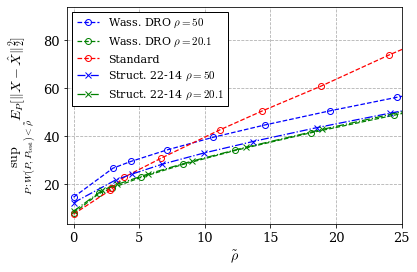

In [ ]:
# plot

saved = torch.load(f'saved_results/wcd_wassDRO_d{d}L{L}gamma_train{1:.2f}.pt')
wcd_DRO, rhos_DRO = saved['wcd'], saved['rhos']
saved = torch.load(f'saved_results/wcd_wassDRO_d{d}L{L}rho50.pt')
wcd_DRO2, rhos_DRO2 = saved['wcd'], saved['rhos']
saved = torch.load(f'saved_results/wcd_std_d{d}L{L}.pt')
wcd_std, rhos_std = saved['wcd'], saved['rhos']
saved = torch.load(f'saved_results/wcd_structured_d{d_pair[0]}-{d_pair[1]}L{L}gamma_train{1:.2f}.pt', map_location=device)
wcd_structured, rhos_structured = saved['wcd'], saved['rhos']
saved = torch.load(f'saved_results/wcd_structured_d{d_pair[0]}-{d_pair[1]}L{L}rho{rho}.pt')
wcd_structured2, rhos_structured2 = saved['wcd'], saved['rhos']

# run distortion on center section below first
rhos_std = np.insert(np.flip(rhos_std), 0, 0)
rhos_DRO = np.insert(np.flip(rhos_DRO), 0, 0)
rhos_DRO2 = np.insert(np.flip(rhos_DRO2), 0, 0)
rhos_structured = np.insert(np.flip(rhos_structured), 0, 0)
rhos_structured2 = np.insert(np.flip(rhos_structured2), 0, 0)
wcd_std = np.insert(np.flip(wcd_std), 0, center_std)
wcd_DRO = np.insert(np.flip(wcd_DRO), 0, center_DRO)
wcd_DRO2 = np.insert(np.flip(wcd_DRO2), 0, center_DRO2)
wcd_structured = np.insert(np.flip(wcd_structured), 0, center_structured)
wcd_structured2 = np.insert(np.flip(wcd_structured2), 0, center_structured2)

## extended rho

plt.figure()
plt.plot(rhos_DRO2, wcd_DRO2, '--o', label=r'Wass. DRO $\rho=50$', mfc='none')
plt.plot(rhos_DRO, wcd_DRO, '--o', label=r'Wass. DRO $\rho=20.1$', mfc='none')
plt.plot(rhos_std, wcd_std, '--o', label='Standard', mfc='none')
plt.plot(rhos_structured2, wcd_structured2, '-.x', color='b', label=fr'Struct. {d_pair[0]*np.log2(L):.0f}-{d_pair[1]*np.log2(L):.0f} $\rho=50$', mfc='none')
plt.plot(rhos_structured, wcd_structured, '-.x', color='g', label=fr'Struct. {d_pair[0]*np.log2(L):.0f}-{d_pair[1]*np.log2(L):.0f} $\rho=20.1$', mfc='none')
# plt.axvline(20.1,  color='b', linestyle='--', label=r'$\rho_{\mathrm{train}}$')
plt.grid(linestyle='--')
plt.xlabel(r'$\tilde{\rho}$' , fontsize=14)
plt.ylabel(r'$\sup_{P:W(P,P_{\mathrm{test}})<\tilde{\rho}} E_P[\|X-\hat{X}\|_2^2]$', fontsize=14)
# plt.xlim([-1, min(rhos_DRO2[-1], rhos_DRO[-1], rhos_std[-1], rhos_structured2[-1], rhos_structured[-1])])
plt.xlim([-0.5, 25])
# plt.ylim([5, 25])
plt.legend(prop={'size': 11})
# plt.tight_layout()
# plt.show()
# plt.savefig(f'plots/wcd_R{d*np.log2(L):.2f}_short.pdf')
# plt.savefig(f'plots/wcd_R{d*np.log2(L):.2f}_d{d_pair[0]}-{d_pair[1]}_short.pdf')

In [ ]:
wcd_DRO

array([ 7.71958351, 16.05598497, 18.42568321, 22.7513052 , 28.14375973,
       33.99639053, 41.35576172, 48.6470623 , 55.22624207])

__Distortion on center__

In [ ]:
d = 10

In [ ]:
# load a model (for standard or wassDRO)
# saved = torch.load(f'trained_dro_NEW/ae_c_d{d}L{L}gamma{1.00:.2f}.pt', map_location=device)
# saved = torch.load(f'trained_dro_NEW/ae_c_d{d}L{L}gamma0.97rho20.1.pt', map_location=device)
saved = torch.load(f'trained_dro_NEW/ae_c_d{d}L{L}rho50.pt', map_location=device)
# saved = torch.load(f'trained_no_robust/ae_c_d{d}L{L}.pt', map_location=device)
model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])

In [ ]:
center_std = center_distortion(model, test_loader)
center_std

7.446418905258179

In [ ]:
center_std = 7.446418905258179
# center_std = 16.1

In [ ]:
center_DRO2 = center_distortion(model, test_loader)
center_DRO2

14.511297130584717

In [ ]:
center_DRO = center_distortion(model, test_loader)
center_DRO

7.793619537353516

In [ ]:
# load a model (for structured)
# saved = torch.load(f'trained_idea3_sweep_NEW/ae_c_d{d_pair[0]}-{d_pair[1]}L{L}gamma{1:.2f}.pt', map_location=device)
saved = torch.load(f'trained_idea3_annealed/ae_c_d{d_pair[0]}-{d_pair[1]}L{L}rho{rho}.pt', map_location=device)
model = SingleEncMultiDec(saved['netE'], saved['netQ'], saved['dec_list'], saved['dim_list'])

In [ ]:
center_structured = center_distortion(model,test_loader, 1)
center_structured

8.656077861785889

In [ ]:
center_structured2 = center_distortion(model,test_loader, 1)
center_structured2

12.190348529815674

__Tradeoff vs rate__

In [ ]:
d_sweep = np.arange(4, 11)
d_std = np.zeros(len(d_sweep))
for i, d in enumerate(d_sweep):
    saved = torch.load(f'trained_no_robust/ae_c_d{d}L{L}.pt', map_location=device)
    model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])
    d_std[i] = awgn_distortion(model, 0, test_loader)

In [ ]:
d_std = np.array([19.29276714, 16.00543652, 13.3329649 , 11.30728674,  9.66215181,
        8.41576381, 7.44])

In [ ]:
d_sweep = np.arange(4, 11)
d_DRO = np.zeros(len(d_sweep))
for i, d in enumerate(d_sweep):
    saved = torch.load(f'trained_dro_NEW/ae_c_d{d}L{L}gamma{1.00:.2f}.pt', map_location=device)
    model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])
    d_DRO[i] = center_distortion(model, test_loader)

In [ ]:
d_DRO2 = np.zeros(len(d_sweep))
for i, d in enumerate(d_sweep):
    saved = torch.load(f'trained_dro_NEW/ae_c_d{d}L{L}rho50.pt', map_location=device)
    model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])
    d_DRO2[i] = center_distortion(model, test_loader)

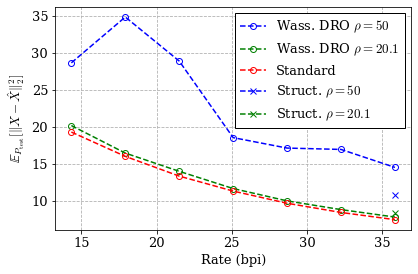

In [ ]:
plt.figure()
plt.plot(np.log2(L)*d_sweep, d_DRO2, '--o', label=r'Wass. DRO $\rho=50$', mfc='none')
plt.plot(np.log2(L)*d_sweep, d_DRO, '--o', label=r'Wass. DRO $\rho=20.1$', mfc='none')
plt.plot(np.log2(L)*d_sweep, d_std, '--o', label='Standard', mfc='none')
plt.plot(np.log2(L)*d_sweep[-1], 10.804, '--x', color='b', label=r'Struct. $\rho=50$', mfc='none')
plt.plot(np.log2(L)*d_sweep[-1], 8.30269747, '--x', color='g', label=r'Struct. $\rho=20.1$', mfc='none')
# plt.plot(rhos_structured, wcd_structured, '--o', label=f'Struct. {d_pair[0]*np.log2(L):.0f}-{d_pair[1]*np.log2(L):.0f} bits', mfc='none')
# plt.axvline(20.1,  color='k', linestyle='--', label=r'$\rho_{\mathrm{train}}$')
plt.grid(linestyle='--')
plt.xlabel('Rate (bpi)')
plt.ylabel(r'$\mathbb{E}_{P_{\mathrm{test}}}[\|X-\hat{X} \|_2^2]$')
# plt.xlim([-1, 5])
# plt.ylim([5, 25])
plt.legend()
plt.tight_layout()
# plt.show()
plt.savefig(f'plots/rate_tradeoff.pdf')
# plt.savefig(f'plots/wcd_R{d*np.log2(L):.2f}_d{d_pair[0]}-{d_pair[1]}rho20.1.pdf')

__First stage of structured compressor__

In [ ]:
# load a model (for standard or wassDRO)
d = d_pair[0]
saved = torch.load(f'trained_no_robust/ae_c_d{d}L{L}.pt', map_location=device)
model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])

In [ ]:
# load a model (for structured)
saved = torch.load(f'trained_idea3_annealed/ae_c_d{d_pair[0]}-{d_pair[1]}L{L}rho{rho}.pt', map_location=device)
# saved = torch.load(f'trained_idea3_sweep_NEW/ae_c_d{d_pair[0]}-{d_pair[1]}L{L}gamma{gamma:.2f}.pt', map_location=device)
model = SingleEncMultiDec(saved['netE'], saved['netQ'], saved['dec_list'], saved['dim_list'])

In [ ]:
#for standard
gammas = np.append(np.linspace(1.68, 2.2, 5), np.linspace(2.5, 3.3, 3))
rhos = np.zeros(len(gammas))

In [ ]:
#for structured 1st stage
gammas = np.append(np.linspace(1.2, 1.8, 5), np.linspace(1.9, 2.5, 3))
rhos = np.zeros(len(gammas))

In [ ]:
dset = torch.utils.data.random_split(train_loader.dataset, [10000, 50000])[0]
train_loader2 = torch.utils.data.DataLoader(dset, batch_size=5000, shuffle=True)
for i, gamma in enumerate(gammas):
#     rhos[i] = est_radius(model, gamma, train_loader2)
    rhos[i] = est_radius_structured(model, gamma, train_loader2, 0) # 1st stage for structured

29.84964942932129
29.728604316711426
22.543737411499023
22.451170921325684
17.573959350585938
17.47284698486328
14.049349784851074


KeyboardInterrupt: ignored

In [ ]:
gammas, rhos

(array([1.2 , 1.35, 1.5 , 1.65, 1.8 , 1.9 , 2.2 , 2.5 ]),
 array([31.99873619, 22.9282505 , 16.69020405, 12.55655622,  9.62870455,
         8.26916418,  5.51929431,  3.99073792]))

In [ ]:
# wcd = eval_robust(model, gammas, test_loader)
wcd = eval_robust(model, gammas, test_loader, 0) # for structured

In [ ]:
rhos = np.array([31.99873619, 22.9282505 , 16.69020405, 12.55655622,  9.62870455,
         8.26916418,  5.51929431,  3.99073792])
rhos = np.append(rhos, 0)

In [ ]:
# center = awgn_distortion(model, 0, test_loader)
center = awgn_distortion(model, 0, test_loader, 0) # for structured
wcd = np.append(wcd, center)

In [ ]:
wcd, rhos

(array([91.6114357 , 76.54870224, 65.30997734, 57.10980034, 50.89048576,
        47.88117371, 41.34399719, 37.09785423, 18.2855999 ]),
 array([31.99873619, 22.9282505 , 16.69020405, 12.55655622,  9.62870455,
         8.26916418,  5.51929431,  3.99073792,  0.        ]))

In [ ]:
# for standard
save = {'rhos': rhos, 'gammas': gammas, 'wcd': wcd}
torch.save(save, f'saved_results/wcd_std_d{d_pair[0]}L{L}.pt')

In [ ]:
# for structured
save = {'rhos': rhos, 'gammas': gammas, 'wcd': wcd}
torch.save(save, f'saved_results/wcd_stg1_d{d_pair[0]}-{d_pair[1]}L{L}.pt')

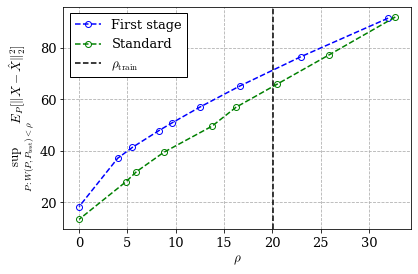

In [ ]:
saved = torch.load(f'saved_results/wcd_stg1_d{d_pair[0]}-{d_pair[1]}L{L}.pt')
wcd_stg1, rhos_stg1 = saved['wcd'], saved['rhos']
saved = torch.load(f'saved_results/wcd_std_d{d_pair[0]}L{L}.pt')
wcd_std, rhos_std = saved['wcd'], saved['rhos']

plt.figure()
plt.plot(rhos_stg1, wcd_stg1, '--o', label='First stage', mfc='none')
plt.plot(rhos_std, wcd_std, '--o', label='Standard', mfc='none')
# plt.plot(rhos_structured, wcd_structured, '--o', label=f'Struct. {d_pair[0]*np.log2(L):.0f}-{d_pair[1]*np.log2(L):.0f} bits', mfc='none')
plt.axvline(20.1,  color='k', linestyle='--', label=r'$\rho_{\mathrm{train}}$')
plt.grid(linestyle='--')
plt.xlabel(r'$\rho$ ')
plt.ylabel(r'$\sup_{P:W(P,P_{\mathrm{test}})<\rho} E_P[\|X-\hat{X}\|_2^2]$')
# plt.xlim([-1, 5])
# plt.ylim([5, 25])
plt.legend()
plt.tight_layout()
# plt.show()
# plt.savefig(f'plots/wcd_R{d*np.log2(L):.2f}_rho20.1.pdf')
# plt.savefig(f'plots/wcd_R{d*np.log2(L):.2f}_d{d_pair[0]}-{d_pair[1]}rho20.1.pdf')

In [ ]:
d_pairs = [(4,6), (5,5), (6,4), (7,3), (8,2), (9,1)]
d_stg1 = np.zeros(len(d_pairs))
d_stg2 = np.zeros(len(d_pairs))
for i, d_pair in enumerate(d_pairs):
    # saved = torch.load(f'trained_idea3_sweep_NEW/ae_c_d{d_pair[0]}-{d_pair[1]}L{L}gamma{gamma:.2f}.pt', map_location=device)
    saved = torch.load(f'trained_idea3_annealed/ae_c_d{d_pair[0]}-{d_pair[1]}L{L}rho{rho}.pt', map_location=device)
    model = SingleEncMultiDec(saved['netE'], saved['netQ'], saved['dec_list'], saved['dim_list'])
    d_stg1[i] = center_distortion(model, test_loader, 0)
    d_stg2[i] = center_distortion(model, test_loader, 1) # for structured
print(d_stg1, d_stg2)

[41.49463463 27.83139153 20.53394508 15.43121376 14.15901098 35.39908295] [14.26291084 11.47662287 12.19034853 10.80405512 11.16263704 13.88954544]


In [ ]:
d_pairs = [(4,6), (5,5), (6,4), (7,3), (8,2), (9,1)]
gamma = 1.00
d_stg1_rho20 = np.zeros(len(d_pairs))
d_stg2_rho20 = np.zeros(len(d_pairs))
for i, d_pair in enumerate(d_pairs):
    saved = torch.load(f'trained_idea3_sweep_NEW/ae_c_d{d_pair[0]}-{d_pair[1]}L{L}gamma{gamma:.2f}.pt', map_location=device)
    # saved = torch.load(f'trained_idea3_annealed/ae_c_d{d_pair[0]}-{d_pair[1]}L{L}rho{rho}.pt', map_location=device)
    model = SingleEncMultiDec(saved['netE'], saved['netQ'], saved['dec_list'], saved['dim_list'])
    d_stg1_rho20[i] = center_distortion(model, test_loader, 0)
    d_stg2_rho20[i] = center_distortion(model, test_loader, 1) # for structured
print(d_stg1_rho20, d_stg2_rho20)

[34.10898094 28.03926849 18.28559952 14.20950184 10.29474688  8.42107277] [9.11747169 8.70407119 8.65607781 8.54213905 8.33872695 8.30269747]


In [ ]:
d_stg1_rho20 = np.array([34.10898018, 28.03926888, 18.2855999 , 14.20950184, 10.29474726,
        8.42107315])

In [ ]:
d_sweep = np.arange(4, 10)
d_std = np.zeros(len(d_sweep))
for i, d in enumerate(d_sweep):
    saved = torch.load(f'trained_no_robust/ae_c_d{d}L{L}.pt', map_location=device)
    model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])
    d_std[i] = center_distortion(model, test_loader)

In [ ]:
d_sweep = np.arange(4, 10)
d_std = np.array([19.29276714, 16.00543652, 13.3329649 , 11.30728674,  9.66215181,
        8.41576381])

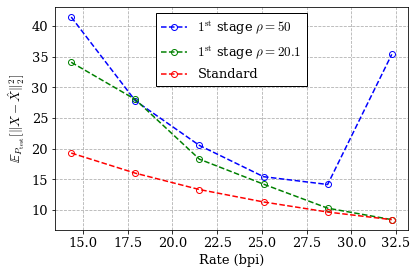

In [ ]:
plt.figure()
plt.plot(np.log2(L)*d_sweep, d_stg1, '--o', label=r'$1^{\mathrm{st}}$ stage $\rho=50$', mfc='none')
plt.plot(np.log2(L)*d_sweep, d_stg1_rho20, '--o', label=r'$1^{\mathrm{st}}$ stage $\rho=20.1$', mfc='none')
plt.plot(np.log2(L)*d_sweep, d_std, '--o', label='Standard', mfc='none')
plt.grid(linestyle='--')
plt.xlabel(r'Rate (bpi)')
plt.ylabel(r'$\mathbb{E}_{P_{\mathrm{test}}}[\|X-\hat{X} \|_2^2]$')
# plt.xlim([-1, 5])
# plt.ylim([5, 25])
plt.legend()
plt.tight_layout()
# plt.show()
# plt.savefig(f'plots/distortion_rate_stg1.pdf')

In [ ]:
saved = torch.load(f'trained_no_robust/ae_c_d{10}L{L}.pt', map_location=device)
model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])
awgn_distortion(model, 0, test_loader)

7.446418905258179

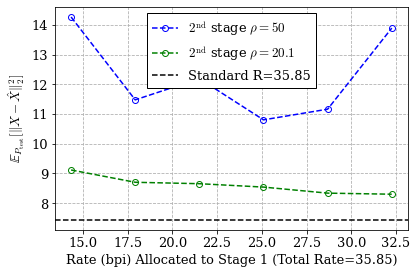

In [ ]:
plt.figure()
plt.plot(np.log2(L)*d_sweep, d_stg2, '--o', label=r'$2^{\mathrm{nd}}$ stage $\rho=50$', mfc='none')
plt.plot(np.log2(L)*d_sweep, d_stg2_rho20, '--o', label=r'$2^{\mathrm{nd}}$ stage $\rho=20.1$', mfc='none')
plt.axhline(7.446418905258179, color='k', linestyle='--', label='Standard R=35.85')
# plt.plot(np.log2(L)*d_sweep, d_std, '--o', label='Standard', mfc='none')
plt.grid(linestyle='--')
plt.xlabel('Rate (bpi) Allocated to Stage 1 (Total Rate=35.85)')
plt.ylabel(r'$\mathbb{E}_{P_{\mathrm{test}}}[\|X-\hat{X} \|_2^2]$')
# plt.xlim([-1, 5])
# plt.ylim([5, 25])
plt.legend(loc='upper center')
plt.tight_layout()
# plt.show()
plt.savefig(f'plots/rate_alloc_stg2.pdf')

__Evaluate distortion__

In [ ]:
# # idea1
# saved = torch.load(f'trained_idea1/ae_c_d8L{L}gammas5-1.pt', map_location=device)
# model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])
# d1 = eval_robust(model, epsilons, test_loader)
# d_awgn1 = eval_awgn(model, noise_std**2, test_loader)

In [ ]:
# idea1 = {'d1': d1, 'd_awgn1': d_awgn1}
# torch.save(idea1, 'saved_results/idea1.pt')

In [ ]:
# idea 3 both stages
saved = torch.load(f'trained_idea3_sweep/ae_c_d{d_pair[0]}-{d_pair[1]}L{L}gamma{gamma}.pt', map_location=device)
model = SingleEncMultiDec(saved['netE'], saved['netQ'], saved['dec_list'], saved['dim_list'])
# d2 = eval_robust(model, epsilons, test_loader, stage)
d_awgn2_stage0 = eval_awgn(model, noise_std**2, test_loader, 0)
d_awgn2_stage1 = eval_awgn(model, noise_std**2, test_loader, 1)

In [ ]:
idea2 = {'d_awgn_stage0': d_awgn2_stage0, 'd_awgn_stage1': d_awgn2_stage1}
torch.save(idea2, f'saved_results/idea3_d{d_pair[0]}-{d_pair[1]}L{L}gammas{gamma}.pt')

In [ ]:
# wass dro
d = d_pair[0]
saved = torch.load(f'trained_dro/ae_c_d{d}L{L}gamma{gamma}.pt', map_location=device)
model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])
d_WassDRO = None #eval_robust(model, epsilons, test_loader)
d_awgn_WassDRO = eval_awgn(model, noise_std**2, test_loader)

In [ ]:
dro = {'d_WassDRO': d_WassDRO, 'd_awgn_WassDRO': d_awgn_WassDRO}
torch.save(dro, f'saved_results/wassDRO_d{d}L{L}gammas{gamma}.pt')

In [ ]:
# # std low rate
# saved = torch.load(f'trained_idea2_sweep/ae_c_d{d_pair[0]}-{d_pair[1]}L{L}gammas{gamma}.pt', map_location=device)
# model = AutoencoderQ(saved['model0'].encoder, saved['model0'].decoder, saved['model0'].quantizer)
# d_std4 = eval_robust(model, epsilons, test_loader)
# d_awgn_std4 = eval_awgn(model, noise_std**2, test_loader)

In [ ]:
# d4L12 = {'d_std': d_std4, 'd_awgn_std': d_awgn_std4}
# torch.save(d4L12, f'saved_results/d{d_pair[0]}L{L}.pt')

In [ ]:
# # standard high rate
# saved = torch.load(f'trained_no_robust/ae_c_d{d_pair[1]+d_pair[0]}L{L}.pt', map_location=device)
# model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])
# d_std8 = eval_robust(model, epsilons, test_loader)
# d_awgn_std8 = eval_awgn(model, noise_std**2, test_loader)

In [ ]:
# d8L12 = {'d_std': d_std8, 'd_awgn_std': d_awgn_std8}
# torch.save(d8L12, f'saved_results/d{d_pair[1]+d_pair[0]}L{L}.pt')

In [ ]:
# saved = torch.load('saved_results/idea1.pt')
# d1, d_awgn1 = saved['d1'], saved['d_awgn1']
saved = torch.load(f'saved_results/idea3_d{d_pair[0]}-{d_pair[1]}L{L}gammas{gamma}.pt')
d_awgn_stage0, d_awgn_stage1 = saved['d_awgn_stage0'], saved['d_awgn_stage1']
saved = torch.load(f'saved_results/idea2_d{d_pair[0]}-{d_pair[1]}L{L}gammas{gamma}.pt')
d2, d_awgn2 = saved['d2'], saved['d_awgn2']
saved = torch.load(f'saved_results/wassDRO_d{d_pair[0]+d_pair[1]}L{L}gammas{gamma}.pt')
d_WassDRO, d_awgn_WassDRO = saved['d_WassDRO'], saved['d_awgn_WassDRO']
saved = torch.load(f'saved_results/d{d_pair[0]}L{L}.pt')
d_std_low, d_awgn_std_low = saved['d_std'], saved['d_awgn_std']
saved = torch.load(f'saved_results/d{d_pair[0]+d_pair[1]}L{L}.pt')
d_std_high, d_awgn_std_high = saved['d_std'], saved['d_awgn_std']

In [ ]:
# saved['d_std'] = saved.pop('d_std4')
# saved['d_awgn_std'] = saved.pop('d_awgn_std4')

In [ ]:

# torch.save(saved, f'saved_results/d{d_pair[0]}L{L}.pt')

In [ ]:
d_pair

(7, 3)

Text(0.5, 1.0, 'Distortion vs. $\\ell_2$ adversary ')

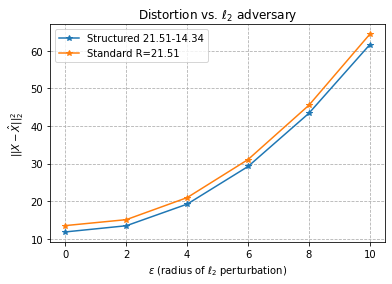

In [ ]:
plt.figure()
# plt.plot(epsilons, d1, '-*')
plt.plot(epsilons, d2, '-*')
# plt.plot(epsilons, d_WassDRO, '-*')
plt.plot(epsilons, d_std_low, '-*')
# plt.plot(epsilons, d_std_high, '-*')
# plt.legend(['Idea 1', 'Idea 2 (structured)', 'WassDRO', 'Standard R=14.34', 'Standard R=28.68'])
plt.legend([f'Structured {d_pair[0]*np.log2(12):.2f}-{d_pair[1]*np.log2(12):.2f}', f'Standard R={d_pair[0]*np.log2(L):.2f}', f'Standard R={(d_pair[0]+d_pair[1])*np.log2(L):.2f}'])
plt.xlabel(r"$\epsilon$ (radius of $\ell_2$ perturbation)")
plt.ylabel(r"$|| X-\hat{X} ||_2^2$")
plt.grid(linestyle='--')
plt.title(f'Distortion vs. $\ell_2$ adversary ')
# plt.show()
# plt.savefig('plots/r25-10_l2adv.pdf')

In [ ]:
d_awgn_stage0

[13.62217664718628,
 14.53642749786377,
 18.060908317565918,
 24.12755012512207,
 32.86080551147461,
 44.17143249511719]

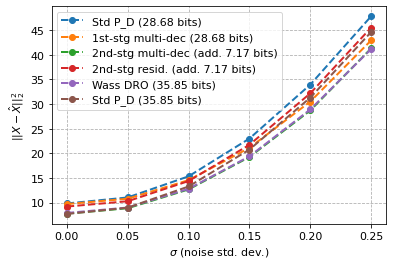

In [ ]:
plt.rcParams.update({'font.size': 11})
plt.rcParams.update({'lines.linewidth':2})

plt.figure()
# plt.plot(noise_std, d_awgn1, '-*')
plt.plot(noise_std, d_awgn_std_low, '--o')
plt.plot(noise_std, d_awgn_stage0, '--o')
plt.plot(noise_std, d_awgn_stage1, '--o')
plt.plot(noise_std, d_awgn2, '--o')
plt.plot(noise_std, d_awgn_WassDRO, '--o')
plt.plot(noise_std, d_awgn_std_high, '--o')
# plt.plot(noise_std, d_awgn_opt, '--*')
# plt.plot(noise_std, cert, '--*')
# plt.legend(['Idea 1', 'Idea 2', r'$\ell_2$ Wass DRO'])
# plt.legend([f'Structured {d_pair[0]*np.log2(12):.2f}-{d_pair[1]*np.log2(12):.2f}', f'Standard R={d_pair[0]*np.log2(L):.2f}', f'Standard R={(d_pair[0]+d_pair[1])*np.log2(L):.2f}'])
plt.legend([f'Std P_D ({d_pair[0]*np.log2(L):.2f} bits)', f'1st-stg multi-dec ({d_pair[0]*np.log2(L):.2f} bits)', f'2nd-stg multi-dec (add. {d_pair[1]*np.log2(12):.2f} bits)', f'2nd-stg resid. (add. {d_pair[1]*np.log2(12):.2f} bits)', f'Wass DRO ({(d_pair[0]+d_pair[1])*np.log2(L):.2f} bits)', f'Std P_D ({(d_pair[0]+d_pair[1])*np.log2(L):.2f} bits)'])
plt.xlabel(r"$\sigma$ (noise std. dev.)")
plt.ylabel(r"$|| X-\hat{X} ||_2^2$")
# plt.xlim([-0.001, 0.16])
# plt.ylim([10, 20])
plt.grid(linestyle='--')
# plt.title(f'Distortion vs. AWGN Noise ')
# plt.show()
# plt.savefig(f'plots/r{d_pair[0]*np.log2(L):.2f}-{d_pair[1]*np.log2(L):.2f}_overall_gamma{gamma:.2f}.pdf')

__distortion vs rate on $P_D$__

In [ ]:
alloc = [(4,6), (5,5), (6,4), (7,3), (8,2)]
L = 12
gamma = 0.36

ind = 5

std_low = []
std_high = []
multidec_1st = []
multidec_2nd = []
residual_2nd = []
wassDRO_low = []
wassDRO_high = []
for d0, d1 in alloc:
    #std low
    saved = torch.load(f'saved_results/d{d0}L{L}.pt')
    std_low += [saved['d_awgn_std'][ind]]
    #std high
    saved = torch.load(f'saved_results/d{d0+d1}L{L}.pt')
    std_high += [saved['d_awgn_std'][ind]]
    #multidec_1st and 2nd
    saved = torch.load(f'saved_results/idea3_d{d0}-{d1}L{L}gammas{gamma:.2f}.pt')
    multidec_1st += [saved['d_awgn_stage0'][ind]]
    multidec_2nd += [saved['d_awgn_stage1'][ind]]
    #residual 2nd
    saved = torch.load(f'saved_results/idea2_d{d0}-{d1}L{L}gammas{gamma:.2f}.pt')
    residual_2nd += [saved['d_awgn2'][ind]]
    #wassDRO low
    saved = torch.load(f'saved_results/wassDRO_d{d0}L{L}gammas{gamma:.2f}.pt')
    wassDRO_low += [saved['d_awgn_WassDRO'][ind]]
    #wassDRO high
    saved = torch.load(f'saved_results/wassDRO_d{d0+d1}L{L}gammas{gamma:.2f}.pt')
    wassDRO_high += [saved['d_awgn_WassDRO'][ind]]               

In [ ]:
std_low

[19.628999710083008,
 16.099703788757324,
 13.500407695770264,
 11.473357200622559,
 9.80080509185791]

In [ ]:
multidec_2nd

[9.120789051055908,
 8.649802684783936,
 8.329551696777344,
 7.978356838226318,
 7.733702182769775]

In [ ]:
wassDRO_low

[19.420866012573242,
 16.17596673965454,
 13.466702938079834,
 11.317937850952148,
 9.784821033477783]

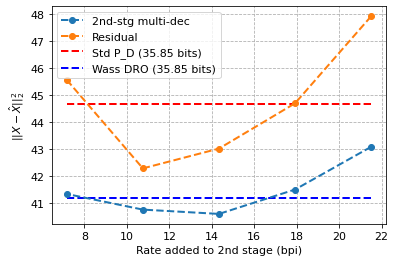

In [ ]:
# plot rate vs dist
# rates_low = np.log2(L)*np.array([pair[0] for pair in alloc])
rates_high = np.log2(L)*np.array([pair[1] for pair in alloc])
# rate_add = np.log2(L)*np.array()
plt.figure()
# plt.plot(rates_low, std_low, '--*')
# plt.plot(rates_low, multidec_1st, '--*')
plt.plot(rates_high, multidec_2nd, '--o')
plt.plot(rates_high, residual_2nd, '--o')
plt.hlines(std_high[0], rates_high[0], rates_high[-1], color='r', linestyles='--')
plt.hlines(wassDRO_high[0], rates_high[0], rates_high[-1], color='b', linestyles='--')
# plt.hlines(wassDRO_low[0], rates_high[0], rates_high[-1], '--')
# plt.plot(rates_low, wassDRO_low, '--*')
# plt.plot(rates, std_high , '--*')
plt.xlabel('Rate added to 2nd stage (bpi)')
plt.ylabel(r"$|| X-\hat{X} ||_2^2$")
plt.legend([f'2nd-stg multi-dec', f'Residual', f'Std P_D ({np.log2(L)*10:.2f} bits)', f'Wass DRO ({np.log2(L)*10:.2f} bits)'])
plt.grid(linestyle='--')
# plt.show()
plt.savefig(f'plots/rate_alloc_AWGNsigma{noise_std[ind]:.2f}_totalR{np.log2(L)*10:.2f}_gamma{gamma:.2f}.pdf')


In [ ]:
file = torch.load('wcd_cert/idea1_d8L12gamma5.pt')
wcd = file['wcd']
cert = file['cert']

In [ ]:
wcd = np.array(wcd)
cert = np.array(cert)

In [ ]:
wcd

array([[2.55038369e+00, 5.61709976e+00],
       [1.46086032e-08, 9.74015691e+00],
       [6.81787320e-08, 9.74095418e+00],
       [1.21219422e-07, 9.74146220e+00],
       [2.15505771e-07, 9.74216651e+00],
       [3.83252996e-07, 9.74304134e+00],
       [6.81167080e-07, 9.74420685e+00],
       [1.21213913e-06, 9.74584457e+00],
       [2.15147838e-06, 9.74799449e+00],
       [3.79828680e-06, 9.75090259e+00],
       [6.53360689e-06, 9.75461489e+00],
       [1.06949956e-05, 9.75915998e+00],
       [1.63714740e-05, 9.76289615e+00],
       [2.33020537e-05, 9.76949137e+00],
       [3.09551742e-05, 9.77459622e+00],
       [3.87163018e-05, 9.77851469e+00],
       [4.60601605e-05, 9.78192314e+00],
       [5.26402819e-05, 9.78444940e+00],
       [5.82894154e-05, 9.78640998e+00],
       [6.29834394e-05, 9.78831431e+00],
       [6.67867971e-05, 9.78983513e+00],
       [6.98105323e-05, 9.79120690e+00],
       [7.21803481e-05, 9.79147788e+00],
       [7.40175019e-05, 9.79209537e+00],
       [7.543016

Text(0.5, 1.0, 'Worst-Case Dist. & Cert. (R=14.34 bpi, $\\gamma = 0.36$)')

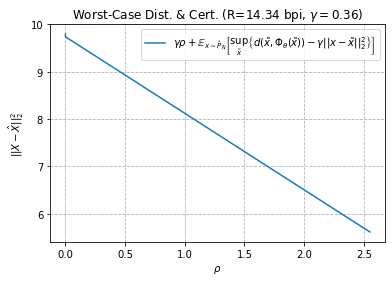

In [ ]:
plt.figure()
# plt.plot(np.linspace(0., 18, 19), cert, '-')
plt.plot(wcd[:,0], wcd[:,1])
plt.xlabel(r"$\rho$")
plt.ylabel(r"$|| X-\hat{X} ||_2^2$")
# plt.vlines(4.644, ymin=19, ymax=30, ls='--', color='k')
# plt.xlim([0, 18]) 
# plt.ylim([20, 29])
plt.legend([r'$\gamma\rho+\mathbb{E}_{x\sim\hat{P}_N}\left[\sup_\tilde{x} \left\{d(\tilde{x},\Phi_\theta(\tilde{x}))-\gamma || x-\tilde{x} ||_2^2 \right\}\right]$',
           r'$\sup_{P:W(P,\hat{P}_N)<\rho} \mathbb{E}_P[d(X, \Phi_\theta(X))]$',
           r'$\hat{\rho}_N(\theta) = 17.195$ (trained radius using $\gamma$)'])

plt.grid(linestyle='--')
plt.title(f'Worst-Case Dist. & Cert. (R={4*np.log2(L):.2f} bpi, ' + r'$\gamma = 0.36$)')
# plt.show()
# plt.savefig('plots/wcd_cert.pdf')